<a href="https://colab.research.google.com/github/jasantos1976/pucrioMVP2/blob/main/mvp2_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Definição do Problema

MVP 2 - Deep Learning - Processamento de Linguagem Natural

Esse projeto é a segunda parte do conjunto de entregas referentes ao MVP da Sprint 2  - Machine Learning & Analytics.

O objeto desse notebook é treinar um modelo baseado em Deep Learning para resolver um problema de linguagem natural.

O dataset utilizado nesse estudo foi obtido na plataforma Kaggle e pode ser baixado pelo link https://www.kaggle.com/datasets/ishikajohari/best-books-10k-multi-genre-data

O referido dataset é composto com informações sobre os 10k livros mais recomendados para leitura de todos os tempos. Os dados foram coletados do Goodreads da lista "*Books That Everyone Should Read At Least Once*".


**O objetivo a ser alcançado nesse projeto é poder sugerir um livro a partir dos dados da descrição.**



O dataset é composto por 7 atributos descritos abaixo:

**Book** - Nome do livro. Às vezes, isso inclui os detalhes da Série a que pertence entre parênteses. Esta informação pode ser posteriormente extraída para analisar apenas séries.

**Author** - Nome do autor do livro

**Description** - A descrição do livro conforme mencionado no Goodreads

**Genres** - Vários gêneros classificados no Goodreads. Pode ser útil para classificação multi-rótulo ou recomendação baseada em conteúdo e agrupamento. Esse atributo é multivalorado e possivelmente será dividido para facilitar o estudo.

**Average Rating** - A classificação média (de 5) dada no Goodreads

**Number of Ratings** - O número de usuários que possuem Ratings. (Não confundir com resenhas)

**URL** - O URL do Goodreads para a página de detalhes do livro



# 2. Importações das Bibliotecas


In [54]:
import pandas as pd
import numpy as np

# Configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Importação Regular Expression
import re

# nltk
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
from nltk.tokenize import RegexpTokenizer

# Tratamento de missings
import missingno as ms

# Biblioteca sklearn
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Visualização
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
import plotly.graph_objects as go
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# 3. Carga do Dataset

In [ ]:
url_books = 'https://raw.githubusercontent.com/jasantos1976/pucrioMVP2/main/goodreads_data.csv'

# Cria o dataframe passando os atributos com seus respectivos tipos
# e já remove a primeira coluna com números sequenciais
df_books = pd.read_csv(url_books, delimiter=',', index_col=0)
df_books.reset_index(drop=True, inplace=True)

print(df_books)

In [8]:
# Para o estudo proposto, 3 colunas não fazem sentido nesse momento:
# [Avg_Rating, Num_Ratings, URL]
df_books_pred = df_books.loc[:, ['Book', 'Author', 'Description', 'Genres']]


In [17]:
# O atributo [Genres] é multivalorado. Para facilitar a leitura e o treino,
# farei a divisão em outras colunas.
df_books_pred[['Genre_P', 'Genre_S', 'Genre_T', 'GenreQ']] = \
df_books_pred['Genres'].str.split(',', 3, expand=True)

# Eliminando colunas que não são mais necessárias
cols_drop = ['Genres', 'GenreQ']
df_books_pred.drop(cols_drop, axis=1, inplace=True)

# 4. Análise Exploratória

In [18]:
# Obtendo informações do dataset
df_books_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Book         10000 non-null  object
 1   Author       10000 non-null  object
 2   Description  9923 non-null   object
 3   Genre_P      10000 non-null  object
 4   Genre_S      8689 non-null   object
 5   Genre_T      8401 non-null   object
dtypes: object(6)
memory usage: 468.9+ KB


In [10]:
df_books_pred.describe()

,Book,Author,Description,Genres
count,10000,10000,9923,10000
unique,9871,6064,9888,8043
top,"The Oldest Dance (Wisdom Revolution, #2)",Stephen King,This is a reproduction of the original artefac...,[]
freq,4,57,4,960


In [19]:
# Visualizando as primeiras 5 linhas
df_books_pred.head(n=5)

,Book,Author,Description,Genre_P,Genre_S,Genre_T
0,To Kill a Mockingbird,Harper Lee,The unforgettable novel of a childhood in a sl...,['Classics','Fiction','Historical Fiction'
1,Harry Potter and the Philosopher’s Stone (Harr...,J.K. Rowling,Harry Potter thinks he is an ordinary boy - un...,['Fantasy','Fiction','Young Adult'
2,Pride and Prejudice,Jane Austen,"Since its immediate success in 1813, Pride and...",['Classics','Fiction','Romance'
3,The Diary of a Young Girl,Anne Frank,Discovered in the attic in which she spent the...,['Classics','Nonfiction','History'
4,Animal Farm,George Orwell,Librarian's note: There is an Alternate Cover ...,['Classics','Fiction','Dystopia'


In [20]:
# Visualizando as últimas 5 linhas
df_books_pred.tail(n=5)

,Book,Author,Description,Genre_P,Genre_S,Genre_T
9995,"Breeders (Breeders Trilogy, #1)",Ashley Quigley,How far would you go? If human society was gen...,['Dystopia','Science Fiction','Post Apocalyptic'
9996,Dynamo,Eleanor Gustafson,Jeth Cavanaugh is searching for a new life alo...,[],None,None
9997,The Republic of Trees,Sam Taylor,This dark fable tells the story of four Englis...,['Fiction','Horror','Dystopia'
9998,"Waking Up (Healing Hearts, #1)",Renee Dyer,For Adriana Monroe life couldn’t get any bette...,['New Adult','Romance','Contemporary Romance'
9999,Bits and Pieces: Tales and Sonnets,Jas T. Ward,After demands of thousands of fans in various ...,[],None,None


# 5. Pré-processamento dos Dados


## 5.1 Tratamento de Missings e Limpeza

In [23]:
# Na leitura dos dados do dataset, já é possível verificar que as colunas de
# gêneros precisam passar por uma limpeza
patt = r"[a-zA-Z]+"
gen_cols = ['Genre_P', 'Genre_S', 'Genre_T']
for g in gen_cols:
    df_books_pred[g] = df_books_pred[g].apply(
        lambda x: " ".join(re.findall("[a-zA-Z]+", str(x))))

In [25]:
# Verificando os atributos que possuem nulos
df_books_pred.isnull().sum()

Book            0
Author          0
Description    77
Genre_P         0
Genre_S         0
Genre_T         0
dtype: int64

<Axes: >

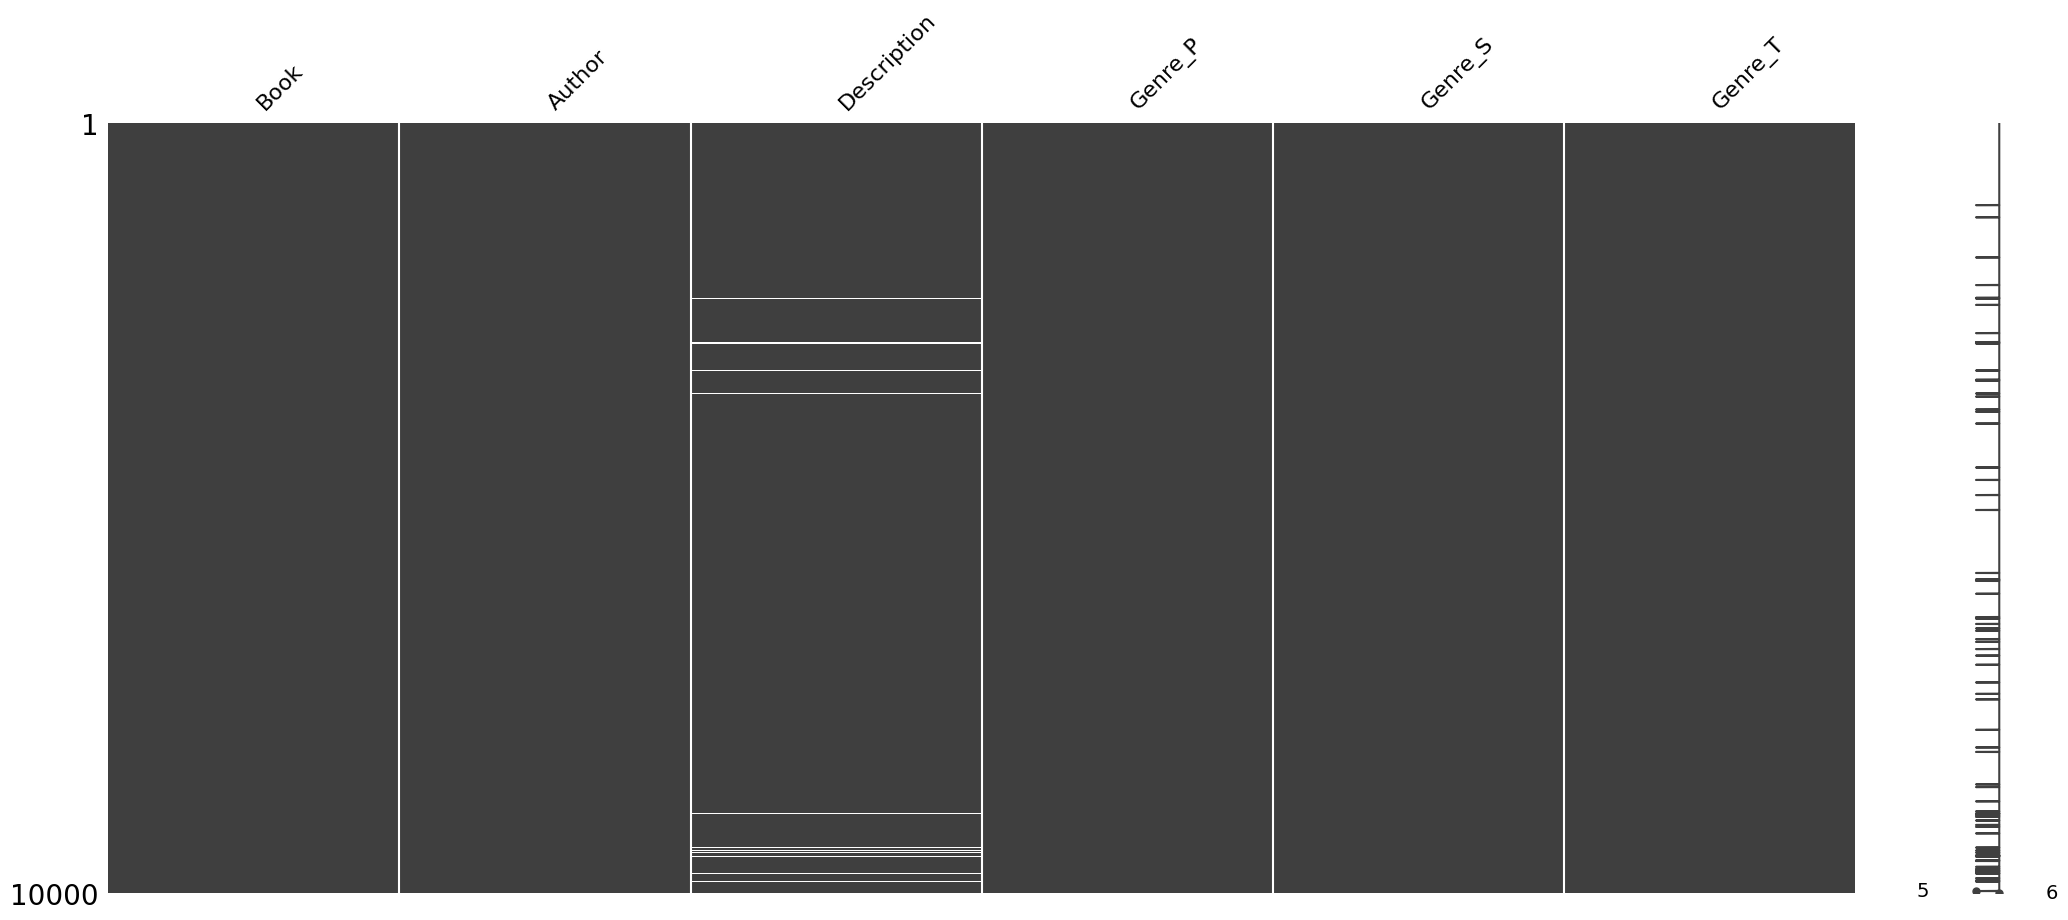

In [28]:
# Exibindo a matriz de nulidade do dataframe
ms.matrix(df_books_pred)

O número de valores nulos é insignificante para o conjunto do dataset.
Como se trata de uma coluna chave para o que se propõe esse estudo, a
decisão será pela exclusão das linhas cujas descrições forem nulas.

In [29]:
# drop NULLs & reset index
df_books_pred.dropna(inplace=True)
df_books_pred.reset_index(drop=True, inplace=True)


## 5.2 N-grams

Utilizarei aqui a técnica TF-IDF para bigram e trigram, que consiste em trabalhar em sequências de 2 ou 3 palavras consecutivas como unidades básicas de análise. Essa técnica permite que o modelo capture mais informações de sequências de palavras, considerando a relação entre palavras vizinhas.

In [33]:
#Convertendo descrição do livro em vetores usando TF-IDF Bigram
tf_bigram = TfidfVectorizer(ngram_range=(2, 2),
                            stop_words='english', lowercase = False)
tfidf_matrix_bigram = tf_bigram.fit_transform(df_books_pred['Description'])
total_words_bi = tfidf_matrix_bigram.sum(axis=0)

#Localizando a frequencia da palavra
freq_word = [(word, total_words_bi[0, idx]) for word,
             idx in tf_bigram.vocabulary_.items()]
freq_word = sorted(freq_word, key = lambda x: x[1], reverse=True)

#Convertendo em dataframe
df_bigram = pd.DataFrame(freq_word)
df_bigram.rename(columns = {0:'bigram', 1: 'count'}, inplace = True)



#Convertendo descrição do livro em vetores usando TF-IDF Trigram
tf_trigram = TfidfVectorizer(ngram_range=(3, 3),
                             stop_words='english', lowercase = False)
tfidf_matrix_trigram = tf_trigram.fit_transform(df_books_pred['Description'])
total_words_trigram = tfidf_matrix_trigram.sum(axis=0)

#Localizando a frequencia da palavra
freq_word = [(word, total_words_trigram[0, idx]) for word,
             idx in tf_trigram.vocabulary_.items()]
freq_word = sorted(freq_word, key = lambda x: x[1], reverse=True)

#converting into dataframe
df_trigram = pd.DataFrame(freq_word)
df_trigram.rename(columns = {0:'trigram', 1: 'count'}, inplace = True)


In [40]:
print(df_bigram.head(10))

               bigram      count
0            New York  34.061025
1            year old  32.966574
2           This book  20.928422
3          York Times  20.456094
4           World War  14.329714
5         best friend  14.076418
6           years ago  12.888485
7  bestselling author  12.880781
8       United States  11.726320
9         young woman  11.302555


In [44]:
print(df_trigram.head(10))

                    trigram      count
0            New York Times  20.132448
1    York Times bestselling  10.195514
2              World War II   8.392039
3             New York City   8.328253
4  Times bestselling author   7.237586
5   alternate cover edition   5.335741
6              The New York   5.142864
7        cover edition ISBN   4.685541
8     York Times bestseller   4.657821
9   Alternate cover edition   4.582805


In [46]:
# Visualizando o bigram
n = 10
bigram = df_bigram.head(n)

# plot Bigram
fig = go.Figure(data=[go.Bar(x=df_bigram['bigram'].to_list(),
                             y=df_bigram['count'].to_list(),
            hovertext=df_bigram['count'].to_list())])

# Customize aspect
fig.update_traces(marker_color='rgb(255,135,91)',
                  marker_line_color='rgb(65,53,255)',
                  marker_line_width=1.5, opacity=0.6)
fig.update_layout(title_text="Distribuição Bigram para as top " + str(n) +
                  " palavras contidas na descrição do livro")
fig.show()

In [42]:
# Visualizando o Trigram
trigram = df_trigram.head(n)

# plot Trigram
fig = go.Figure(data=[go.Bar(x=df_trigram['trigram'].to_list(),
                             y=df_trigram['count'].to_list(),
            hovertext=df_trigram['count'].to_list())])

# Customize aspect
fig.update_traces(marker_color='rgb(255,135,91)',
                  marker_line_color='rgb(65,53,255)',
                  marker_line_width=1.5, opacity=0.6)
fig.update_layout(title_text="Distribuição Trigram para as top " + str(n) +
                  " palavras contidas na descrição do livro")
fig.show()

## 5.3 Stop-words

In [55]:
# Removendo stop_word
def remove_stop_words(text):
    text = text.split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text

df_books_pred['Desc_Clean'] = df_books_pred.Description.apply(
    func = remove_stop_words)